<img src="images/Picture0.png" width=200x />

# Notebook 02b - Simple Linear Regression - Supplement

## Instructions
...

## Pre-requisites
...

## Credits
...


## If you are using Colab, save a copy of this notebook!!

Before we get started, it is crucially important that you **save a copy of the notebook** to a local folder if you are accessing this notebook in Google Colab! Please go to:

```
File -> Make a copy
```


In [ ]:
#@title (Hidden) Diagnostic Check
import os
import sys
import pandas as pd
import numpy as np
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/ciaran-evans/bryozoan-data-paper/master/bryozoan_data_fixed.csv')
display(data)


,Species,Run,Stage,Mass,Metabolic
0,bugula,1,early,13.314606,0.166753
1,bugula,1,early,14.755931,0.144465
2,bugula,1,early,11.584298,0.170493
3,bugula,1,early,14.402104,0.163918
4,bugula,1,early,12.691213,0.134369
...,...,...,...,...,...
818,watersipora,21,larvae,15.865291,0.522338
819,watersipora,21,larvae,17.707463,0.654469
820,watersipora,21,larvae,18.442676,0.477994
821,watersipora,21,larvae,22.187924,0.747301


### Scaling/Normalizing Data

When thinking about data, realize that each data point may have vastly different magnitudes/sizes. As a result, it sometimes is a good idea to normalize information into a standard form to help make a decision. For instance, what is a better deal? Getting a 4 dollar Iced Mocha (down from 6.42) or getting $500 dollars off a new computer that costs 1,500 dollars?

Enter the Z-Score, which aims to help with normalizing values:

$$z = \frac{x - \mu}{\sigma}$$

To calculate the Z-Score you need to calculate:

- the mean($\mu$)

$$\mu = \bar{x} = \frac{x_1+x_2+\cdots +x_n}{n}$$

- the standard deviation ($\sigma$)

$$\sigma = \sqrt{\frac{1}{n} \sum_{i=1}^n (x_i - \mu)^2}, \text{ where } \mu = \frac{1}{n} \sum_{i=1}^n x_i$$

### Regression Tips

It can be helpful to scale and standardize your covariates before throwing them in a regression model. This can be helpful in multiple regression when the different covariates are on different scales. It can also aid in interpretation (i.e. a one unit change in X is associated with an ____ standard deviation increase in Y).

In [ ]:
data.Mass.mean()


15.917655815907272

In [ ]:
np.std(data.Mass)

3.707708013290525

In [ ]:
z_mass = (data.Mass - data.Mass.mean())/np.std(data.Mass)
z_mass.head()

data['z_mass'] = z_mass


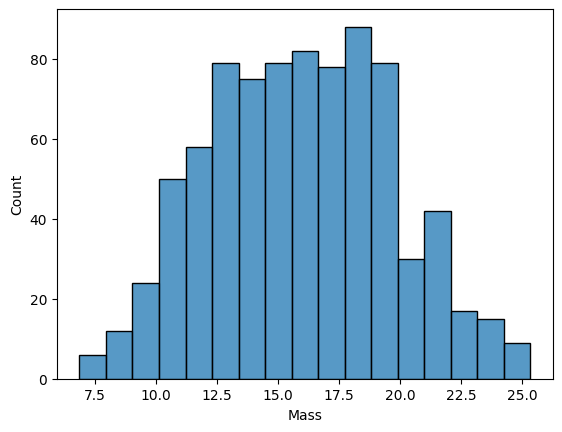

In [ ]:
sns.histplot(data=data, x="Mass");

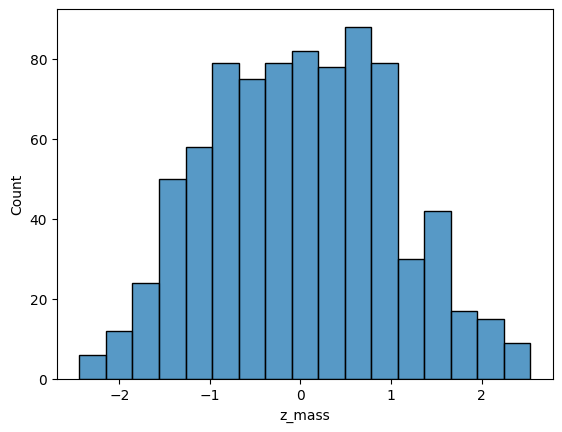

In [ ]:
sns.histplot(data=data, x="z_mass");

### Discretizing Data

When working with continuous data, we may sometimes wish to reduce the data into a set of categories. The process of applying thresholds to continuous data is called **discretizing**. For example, within the medical field you may receive a test where your blood pressure is 110 and be categorized as having "Normal" blood pressure.

Category | Numerical Result
----|----
Normal |	Less Than 120
Elevated |	120 – 129
High Blood Pressure (Hypertension) Stage 1 |	130 – 139
High Blood Pressure (Hypertension) Stage 2 |	140 - 180

We can automate this process using either a set of `if-else if-else` statements or use [`.cut(variable, [intervals])`](https://pandas.pydata.org/docs/reference/api/pandas.cut.html) method built-in to Pandas.

In [ ]:
health_data = pd.DataFrame({
    "bloodpressure": [110, 115, 139, 140, 145]
})
display(health_data)

Reading from the table, we would construct the following thresholds:

In [ ]:
health_data['category'] = pd.cut(health_data['bloodpressure'], [0, 120, 130, 140, 180, np.inf])
display(health_data)

Instead of viewing thresholds, the category should likely match with how a doctor would read the result. That is, we need to apply the five distinct blood pressure classes.

In [ ]:
health_data['category'] = pd.cut(
    health_data['bloodpressure'],
    bins = [0, 120, 130, 140, 180, np.inf],
    labels = ["Normal", "Elevated", "Stage 1", "Stage 2", "Unknown"])
display(health_data)

### Your Turn

Use the bryozoan data loaded above to:

- normalize a different variable other than Mass
- create a discretized variable from the Mass variable


## Missingness

The data set we are working with is relatively "clean". That is, all information is accounted for across each row and column. Nothing is amiss.

In practice, data that is "complete" is a rarity to have. In fact, we often have data that is "incomplete" or contains missing values. Two instances of this behavior come into mind:

1. missing is properly denoted, and
2. coded as present, but really missing.

As we discussed previously, data that is missing is denoted by `NaN` using `NumPy`'s `np.nan`. In other languages, you may see a missing value denoted by either `NA` or `NULL`.

In [ ]:
np.nan

nan

This value is special in the sense that any operation on a missing value will yield a new missing value. Take for instance:

In [ ]:
1 + np.nan

In [ ]:
0 + np.nan

Thankfully, Pandas has pre-built methods that take into account variables that contain missing values. For instance, let's consider two series: 1. complete and 2. incomplete

In [ ]:


full_data = pd.Series([1, 2, 3, 4])
missing_data = pd.Series([np.nan, 2,3 , 4])
              #                # ^^^^^

print(f"Complete Data:\n{full_data}\n")
print(f"Incomplete Data:\n{missing_data}")

Complete Data:
0    1
1    2
2    3
3    4
dtype: int64

Incomplete Data:
0    NaN
1    2.0
2    3.0
3    4.0
dtype: float64


Performing the aggregations with series frames yields notably different results:

In [ ]:
full_data.sum(), full_data.min(), full_data.max()

In [ ]:
missing_data.sum(), missing_data.min(), missing_data.max()

### Methods for Missing Data

df.method() | description
--- | ----
.dropna() | Drop missing observations
.dropna(how='all') | Drop observations where all cells is NA
.dropna(axis=1, how='all') | Drop column if all the values are missing
.dropna(thresh = 5) | Drop rows that contain less than 5 non-missing values
.fillna(0) | Replace missing values with zeros
.isnull()  | True if the value is missing
.notnull() |  True for non-missing values

#### Verify Presence of Missingness

Let's verify the data imported correctly by checking for any [missing values](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html).


In [ ]:
# Read in Data
uci_adult_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
     sep = ",",
     header = None,
     na_values = ['NA','?']
  )
uci_adult_df.isnull().values.any()

False

In [ ]:
# Add all column names
uci_adult_df.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]


This looks great... But, we probably should cause an issue.

For this problem, we introduce NumPy's `np` to insert a `NaN` or "Not-a-Number" value within the `DataFrame`.

In [ ]:
# Create a copy
uci_adult_df_na = uci_adult_df.copy(deep = True)

# Infect with a missing value
uci_adult_df_na.loc[0:1000, ('Age')] = np.nan

We can check our disruptive work by peeking at the "head" of the data set.

In [ ]:
uci_adult_df_na.head(2)

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,NaN,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,NaN,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K



Now, if we re-run the previous code, we should detect a missing value in the data.

In [ ]:
uci_adult_df_na.isnull().values.any()

True

#### Identifying Locations of Missingness

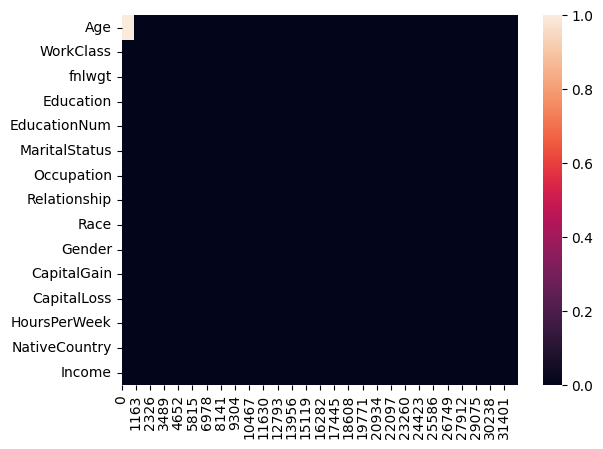

In [ ]:
sns.heatmap(uci_adult_df_na.isnull().transpose());

Each row that contains a _single_ missing value is  displayed in yellow next to the variable name.

Moreover, any row with a _single_ missing could be directly subset by going across `axis = 1` (row-wise).

In [ ]:
uci_adult_df_na[ uci_adult_df_na.isnull().any(axis=1) ].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Age
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,NaN
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,NaN
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,NaN
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,NaN
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,NaN


## We want to understand capital gains. What would happen if...

- some individual records were completely missing? (some records just didn't make it in the dataset due to a glitch)
- older respondents were sensitive to reporting their age?
- it was harder to reach people with education profiles less than a Bachelors degree?

## Check your understanding

Here is a hypothetical model output for a multiple linear regression model of the response (frozen pizza rating on a 5 point scale) as modeled by a variety of covariates. Circle a coefficient that is statistically significant but not practically significant. Explain your reasoning in a sentence or two.

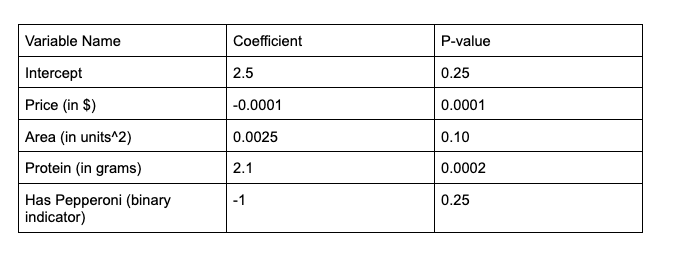

You calculate a 95% confidence interval for the coefficient on the “Has Pepperoni” covariate and it is (-2, -0.5). How do you know you made a calculation error? Explain in a sentence or two.
